STAT 479: Machine Learning (Fall 2018)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-fs2018/

# L13: Dimensionality Reduction 1 -- Feature Selection

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -p sklearn,mlxtend -v

Sebastian Raschka 2018-11-26 

CPython 3.6.5
IPython 6.5.0

sklearn 0.20.0
mlxtend 0.15.0dev


<br>
<br>

## Iris Overview

In [2]:
from mlxtend.data import iris_data
from mlxtend.plotting import scatterplotmatrix
import matplotlib.pyplot as plt


X, y = iris_data()


names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X[y==0], figsize=(12, 10), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.legend(['setosa', 'versicolor', 'virginica'])
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 16 Axes>

- Suppose in a real-world, high dimensional dataset, we cannot intuitively tell which the good features are

<br>
<br>

<br>
<br>

## Feature Importance from Linear Model Coefficients

### Binary Class

![](code-figures/logreg.png)

In [3]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X[50:150], y[50:150], test_size=0.3, random_state=1, stratify=y[50:150])


pipe = make_pipeline(StandardScaler(),
                     # params below actually not necessary:
                     LogisticRegression(solver='newton-cg', multi_class='multinomial'))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 96.67%


In [4]:
lr_model = pipe.named_steps.logisticregression
lr_model.coef_

array([[-0.09211828, -0.29927205,  1.27812501,  1.22789905]])

In [5]:
np.abs(lr_model.coef_)

array([[0.09211828, 0.29927205, 1.27812501, 1.22789905]])

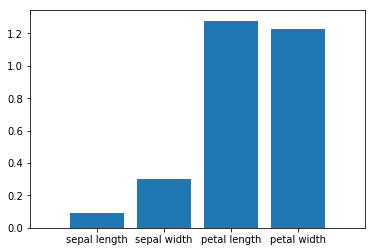

In [6]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), np.abs(lr_model.coef_.flatten()))
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

### Multi-Class

![](code-figures/multinomial-logreg.png)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


pipe = make_pipeline(StandardScaler(),
                     LogisticRegression(solver='newton-cg', multi_class='multinomial'))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 97.78%


In [8]:
lr_model = pipe.named_steps.logisticregression
lr_model.coef_

array([[-1.05554231,  1.01406239, -1.75805264, -1.60180046],
       [ 0.22718366, -0.26599486, -0.13917565, -0.58186585],
       [ 0.82835866, -0.74806753,  1.89722829,  2.18366631]])

In [9]:
coefs = np.sum(np.abs(lr_model.coef_), axis=0)
coefs

array([2.11108463, 2.02812478, 3.79445658, 4.36733262])

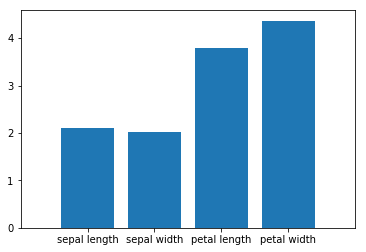

In [10]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), coefs)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

## Feature Importance via Permutation

- http://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/

In [11]:
from mlxtend.evaluate import feature_importance_permutation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [13]:
pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(n_neighbors=3))

pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 95.56%


In [14]:
imp_vals, _ = feature_importance_permutation(
    predict_method=pipe.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=100,
    seed=1)

imp_vals

array([0.03711111, 0.07066667, 0.20488889, 0.31022222])

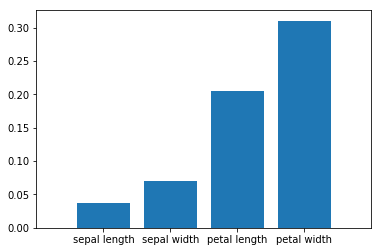

In [15]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), imp_vals)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

## Random Forest Feature Importance

In [16]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=100, random_state=123)
forest.fit(X_train, y_train);

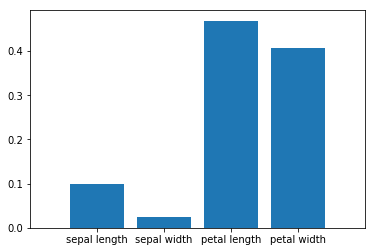

In [17]:
fig, ax = plt.subplots()

ax.bar(range(X_train.shape[1]), forest.feature_importances_)
ax.set_xlim([-1, X.shape[1]])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(['sepal length', 'sepal width', 'petal length', 'petal width'])
plt.show()

<br>
<br>

<br>
<br>

## Sequential Feature Selection

- http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(n_neighbors=5))

sfs1 = SFS(pipe, 
           k_features=4, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished

[2018-11-26 21:58:14] Features: 1/4 -- score: 0.9416666666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2018-11-26 21:58:14] Features: 2/4 -- score: 0.9583333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-11-26 21:58:14] Features: 3/4 -- score: 0.9333333333333333[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [19]:
sfs1.subsets_

{1: {'feature_idx': (2,),
  'cv_scores': array([1.        , 0.91666667, 1.        , 0.91666667, 0.91666667,
         1.        , 1.        , 0.88888889, 0.88888889, 0.88888889]),
  'avg_score': 0.9416666666666667,
  'feature_names': ('2',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([1.        , 1.        , 1.        , 1.        , 0.91666667,
         1.        , 0.88888889, 1.        , 0.88888889, 0.88888889]),
  'avg_score': 0.9583333333333334,
  'feature_names': ('2', '3')},
 3: {'feature_idx': (0, 2, 3),
  'cv_scores': array([1.        , 0.91666667, 0.91666667, 0.91666667, 0.91666667,
         1.        , 0.88888889, 1.        , 0.88888889, 0.88888889]),
  'avg_score': 0.9333333333333333,
  'feature_names': ('0', '2', '3')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([1.        , 1.        , 0.91666667, 0.83333333, 0.91666667,
         1.        , 1.        , 0.88888889, 0.88888889, 0.88888889]),
  'avg_score': 0.9333333333333333,
  'feature_names': ('0', '1', '2

In [20]:
import pandas as pd


pd.DataFrame.from_dict(sfs1.get_metric_dict(confidence_interval=0.90)).T

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.941667,0.0295001,"[1.0, 0.9166666666666666, 1.0, 0.9166666666666...","(2,)","(2,)",0.0488289,0.0162763
2,0.958333,0.0311713,"[1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, ...","(2, 3)","(2, 3)",0.0515949,0.0171983
3,0.933333,0.0272676,"[1.0, 0.9166666666666666, 0.9166666666666666, ...","(0, 2, 3)","(0, 2, 3)",0.0451335,0.0150445
4,0.933333,0.035362,"[1.0, 1.0, 0.9166666666666666, 0.8333333333333...","(0, 1, 2, 3)","(0, 1, 2, 3)",0.0585314,0.0195105


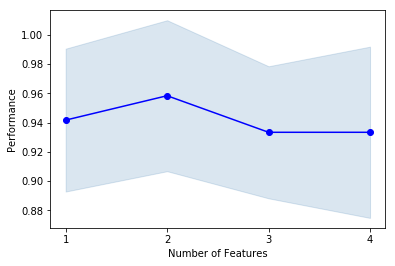

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

### Pipeline

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(),
                     SFS(estimator=KNeighborsClassifier(n_neighbors=5), k_features=2),
                     KNeighborsClassifier(n_neighbors=5))


pipe.fit(X_train, y_train)
print('Test Accuracy %.2f%%' % (100*pipe.score(X_test, y_test)))

Test Accuracy 100.00%
